In [1]:
from hydra.utils import instantiate
import yaml
import torch
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import aics_shape_modes

In [2]:
# config = yaml.safe_load('''
# _target_: aics_im2im.models.vae.ImageVAE

# latent_dim: 256
# spatial_dims: 3
# in_shape: [1, 32, 32, 32]
# out_channels: 1
# channels: [2, 2, 2, 2]
# strides: [1, 1, 1, 1]

# x_label: image
# id_label: null

# kernel_size: 3
# up_kernel_size: 3
# num_res_units: 0
# act: relu
# norm: batch
# dropout: null
# bias: false
# beta: 1.0

# reconstruction_loss:
#   _target_: torch.nn.modules.loss.MSELoss
#   reduction: sum

# encoder_out_size: 256
# prior:
#   _target_: aics_im2im.models.vae.priors.IdentityPrior
#   dimensionality: 256

# use_sigmoid: False

# optimizer:
#   _partial_: true
#   _target_: torch.optim.adam.Adam
#   lr: 0.001
# ''')
# model = instantiate(config)

In [2]:
from aics_im2im.models.utils.mlflow import load_model_from_checkpoint

model = load_model_from_checkpoint("https://mlflow.a100.int.allencell.org", "51f89d15916a4c91b5692ecf4bea174e"
                                  , path = "checkpoints/val loss/best.ckpt", strict=False)
# 9a6c049844434b448786c82cd26db811 # npm1
# cce7b70ea6a64b1f8de36fa434089863 # mem

22-Mar-23 11:33:30 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [3]:
device = "cuda:0"
model = model.to(device)
model = model.eval()

In [5]:
config = yaml.safe_load('''
_target_: aics_im2im.datamodules.DataframeDatamodule
_convert_: all

path: /allen/aics/assay-dev/users/Alex/handoff/ritvik/npm_manifest_with_sdfs.csv
split_column: split

batch_size: 1
num_workers: 1
multiprocessing_context: spawn
persistent_workers: true

transforms:
  - _target_: aics_im2im.dataframe.transforms.GroupCols
    groups:
      image: sdf_path_align_3dnuc
      cell_id: CellId
  - _target_: aics_im2im.image.io.ReadNumpyFile
    keys: image
    remote: false
    clip_min: -2
    clip_max: 2 
''')


In [6]:
from aics_im2im.datamodules.dataframe import MNISTDataModule

In [7]:
data = instantiate(config)
train_dl = data.train_dataloader()
batch = next(iter(train_dl))

In [11]:
# from aics_shape_modes.represent_3d import get_mesh_from_sdf
# img = batch['image'][1][0].detach().cpu().numpy()
# # img = (img - img.min())/(img.max() - img.min())
# mesh = get_mesh_from_sdf(img)
# mesh.save('test.ply')

In [45]:
# import nbvv
# # nbvv.volshow(all_x_r['image'][0][0].detach().cpu().numpy(), spacing=(1.0, 1.0, 1),channel_names=['1'])
# nbvv.volshow(img, spacing=(1.0, 1.0, 1.0),channel_names=['1'])

In [8]:
import pandas as pd
df = pd.read_csv('/allen/aics/assay-dev/users/Alex/handoff/ritvik/npm_manifest_with_sdfs.csv')
from tqdm import tqdm

all_data_inputs = []
all_data_ids = []
all_inputs = []
count = 0
for i in tqdm(train_dl, total=len(train_dl)):
#     if count > 9000:
#         break
    count += 1
    all_data_ids.append(i['cell_id'])
    all_inputs.append(i)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8272/8272 [00:17<00:00, 476.06it/s]


In [9]:
all_data_ids = [item for sublist in all_data_ids for item in sublist]

In [10]:
np.where(np.array(all_data_ids) == '955601-NPM')[0]
# np.where(np.array(all_data_ids) == '668466-NPM')[0]

array([1215])

In [12]:
batch = all_inputs[1215]

In [55]:
for i in range(1):
    print(batch['image'][i].min(), batch['image'][i].max(), batch['image'][i].mean())

tensor(-1.1256) tensor(2.) tensor(1.9342)


In [15]:
import pytorch_lightning as pl
import torchvision
pl.seed_everything(42)

def rotate(matrix, deg_angle, axis):
    d = len(matrix)
    h = len(matrix[0])
    w = len(matrix[0][0])
    min_new_x = 0
    max_new_x = 0
    min_new_y = 0
    max_new_y = 0
    min_new_z = 0
    max_new_z = 0
    new_coords = []
    angle = radians(deg_angle)

    for z in range(d):
        for y in range(h):
            for x in range(w):

                new_x = None
                new_y = None
                new_z = None

                if axis == "x":
                    new_x = int(round(x))
                    new_y = int(round(y*cos(angle) - z*sin(angle)))
                    new_z = int(round(y*sin(angle) + z*cos(angle)))
                elif axis == "y":
                    new_x = int(round(z*sin(angle) + x*cos(angle)))
                    new_y = int(round(y))
                    new_z = int(round(z*cos(angle) - x*sin(angle)))
                elif axis == "z":
                    new_x = int(round(x*cos(angle) - y*sin(angle)))
                    new_y = int(round(x*sin(angle) + y*cos(angle)))
                    new_z = int(round(z))

                val = matrix.item((z, y, x))
                new_coords.append((val, new_x, new_y, new_z))
                if new_x < min_new_x: min_new_x = new_x
                if new_x > max_new_x: max_new_x = new_x
                if new_y < min_new_y: min_new_y = new_y
                if new_y > max_new_y: max_new_y = new_y
                if new_z < min_new_z: min_new_z = new_z
                if new_z > max_new_z: max_new_z = new_z

    new_x_offset = abs(min_new_x)
    new_y_offset = abs(min_new_y)
    new_z_offset = abs(min_new_z)

    new_width = abs(min_new_x - max_new_x)
    new_height = abs(min_new_y - max_new_y)
    new_depth = abs(min_new_z - max_new_z)

    rotated = np.empty((new_depth + 1, new_height + 1, new_width + 1))
    rotated.fill(0)
    for coord in new_coords:
        val = coord[0]
        x = coord[1]
        y = coord[2]
        z = coord[3]

        if rotated[new_z_offset + z][new_y_offset + y][new_x_offset + x] == 0:
            rotated[new_z_offset + z][new_y_offset + y][new_x_offset + x] = val

    matrix = rotated
    return matrix

Global seed set to 42


In [16]:
# batch = next(iter(train_dl))

In [17]:
from math import radians, cos, sin
import torchio

x =  batch['image'][0]
try:
    cell_id = str(batch['cell_id'][0].item())
except:
    cell_id = batch['cell_id'][0]
print(cell_id)

# x =  dl['image'][0]
in_x_2 = x.cpu().numpy()


size =32
resize = torchio.transforms.Resize(target_shape=size)

all_x_r = []
for channel in range(1):
    in_x = in_x_2[channel]
    x_r = np.concatenate((
        resize(np.expand_dims(rotate(in_x, 0*90, 'z'), axis=0)),
#         resize(np.expand_dims(rotate(in_x, 0.5*90, 'z'), axis=0)),
        resize(np.expand_dims(rotate(in_x, 1*90, 'z'), axis=0)),
#         resize(np.expand_dims(rotate(in_x, 1.5*90, 'z'), axis=0)),
        resize(np.expand_dims(rotate(in_x, 2*90, 'z'), axis=0)),
#         resize(np.expand_dims(rotate(in_x, 2.5*90, 'z'), axis=0)),
        resize(np.expand_dims(rotate(in_x, 3*90, 'z'), axis=0)),
#         resize(np.expand_dims(rotate(in_x, 3.5*90, 'z'), axis=0))
), axis=0)
    all_x_r.append(x_r)
all_x_r = np.stack(all_x_r, axis=1) 
all_x_r = torch.tensor(all_x_r)

955601-NPM


In [18]:
all_x_r = all_x_r.float()

In [19]:
import numpy as np
from meshpy.tet import MeshInfo, build
import numpy as np
from ipygany import Scene, TetraMesh
import numpy as np
import mcubes
from skimage import measure


def export_mesh(img_in, filename):
    # Extract the 0-isosurface
    # vertices, triangles = mcubes.marching_cubes(img3,0.5)
    vertices, triangles = mcubes.marching_cubes(img_in,0.5)
#     vertices, triangles = mcubes.marching_cubes(img_in,0)
#     vertices, triangles, _, _ = measure.marching_cubes(img_in, 0)

    # Export the result to sphere.dae
    # mcubes.export_mesh(vertices, triangles, "sphere.dae", "MySphere")
    mcubes.export_obj(vertices, triangles, f'meshes/{filename}.obj')

    vert_list = []
    for i in range(vertices.shape[0]):
        vert_list.append(list(vertices[i]))
    triangles_list = []
    for i in range(triangles.shape[0]):
        triangles_list.append(list(triangles[i]))

    mesh_info = MeshInfo()
    mesh_info.set_points(vert_list)
    mesh_info.set_facets(triangles_list)
    mesh = build(mesh_info)

    # Normalize mesh for viz

    norm_verts = (vertices - vertices.mean(axis=0))/(vertices.std(axis=0))

    vert_list = []
    for i in range(vertices.shape[0]):
        vert_list.append([list(norm_verts[i])[2], list(norm_verts[i])[1], list(norm_verts[i])[0]])
    triangles_list = []
    for i in range(triangles.shape[0]):
        triangles_list.append(list(triangles[i]))
    vertices_norm = np.stack(vert_list, axis=0)
    mcubes.export_obj(vertices_norm, triangles, f'meshes/{filename}_norm.obj')

In [20]:
import vtk
import numpy as np
from vtk.util import numpy_support
import pyvista as pv
import trimesh
import pyacvd
import pandas as pd
from skimage.measure import marching_cubes

def get_mesh_from_sdf(sdf, method="skimage"):
    """
    This function reconstructs a mesh from signed distance function
    values using the marching cubes algorithm. 
    Parameters
    ----------
    sdf : np.array
        3D array of shape (N,N,N) 
    Returns
    -------
    mesh : pyvista.PolyData
        Reconstructed mesh
    """
    if method == "skimage":
        try:
            vertices, faces, normals, _ = marching_cubes(sdf, level=0)
            vert_list = []
            for i in range(vertices.shape[0]):
                vert_list.append(list(vertices[i]))

            norm_verts = (vertices - vertices.mean(axis=0))/(vertices.std(axis=0))

            vert_list = []
            for i in range(vertices.shape[0]):
                vert_list.append([list(norm_verts[i])[2], list(norm_verts[i])[1], list(norm_verts[i])[0]])
            mesh = trimesh.Trimesh(vertices=norm_verts, faces=faces, vertex_normals=normals)
        except: 
            print('empty')
            # empty mesh
            mesh = pv.PolyData()
    else:
        raise NotImplementedError

    mesh = pv.wrap(mesh)
    return mesh

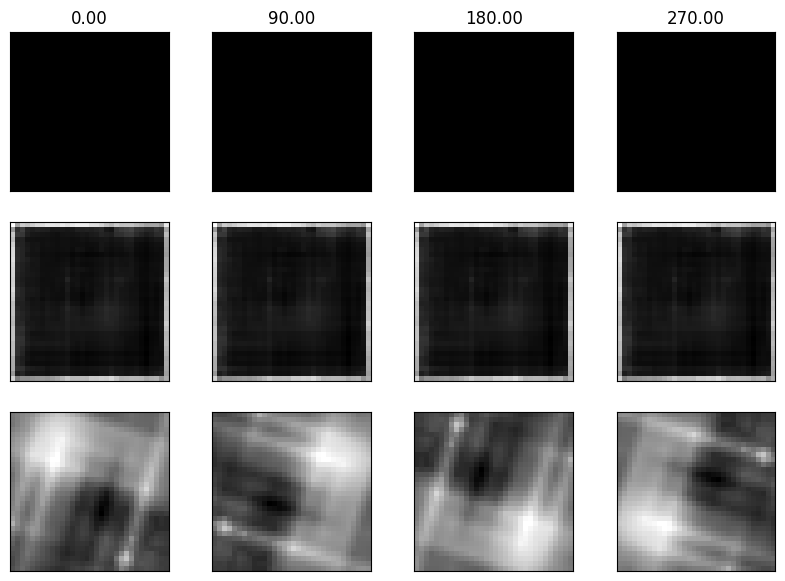

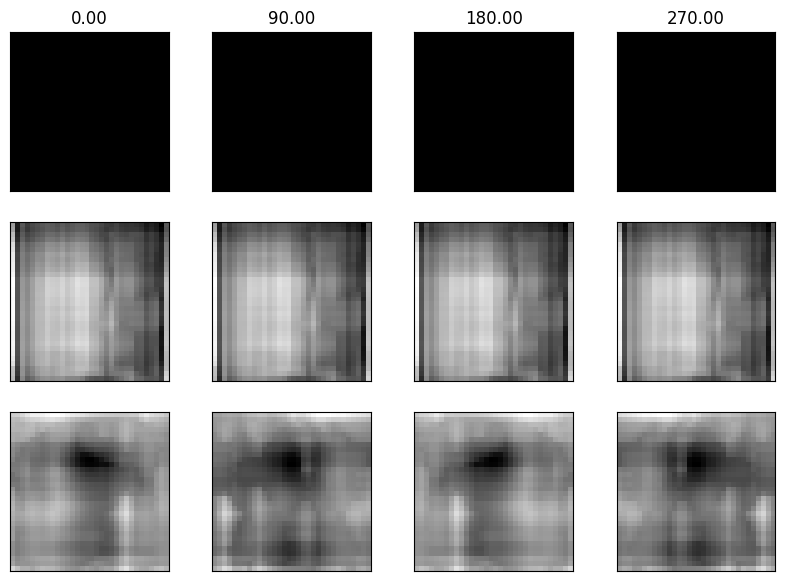

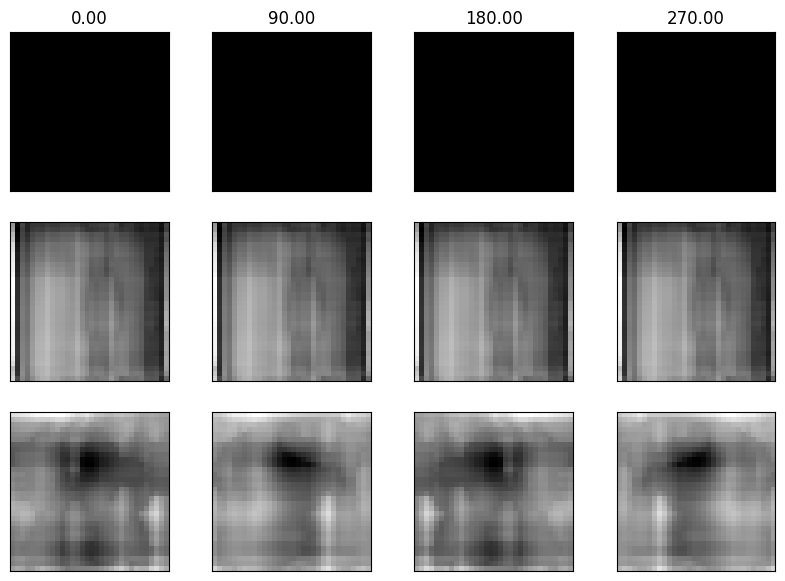

In [21]:
from aics_shape_modes.represent_3d import get_mesh_from_sdf
device = "cuda:0"
all_x_r = {'image': all_x_r.to(device)}

model.to(device)
all_mesh_ins = []
all_mesh_outs = []
all_mesh_outs_canonical = []
# all_z_parts = []
with torch.no_grad():
    z_parts_params = model.encode(all_x_r)
    z_parts = model.sample_z(z_parts_params, inference=True)
    try:
        y, _, base_y = model.decode(z_parts, return_canonical=True)
    except:
        print('exception')
        y, _ = model.decode(z_parts)
        base_y = y['image']
    
    y = y['image'].cpu().numpy()
    base_y = base_y.cpu().numpy()

    for i in range(y.shape[0]): 
# #         all_mesh_ins.append(get_mesh_from_sdf(all_x_r['image'][i][0].detach().cpu().numpy()))
# #         all_mesh_outs.append(get_mesh_from_sdf(y[i][0]))
# #         all_mesh_outs_canonical.append(get_mesh_from_sdf(base_y[i][0]))
        export_mesh(all_x_r['image'][i][0].detach().cpu().numpy(), f'in_{i}')
        export_mesh(y[i][0], f'out_{i}')
        export_mesh(base_y[i][0], f'out_canonical_{i}')
    
#     all_z_parts.append(z_parts['embedding'])
from pathlib import Path
cell_id = cell_id.split('-')[0]
path = Path(f'./reconstructions/ID_{cell_id}/')

import os
if not os.path.exists(path):
    os.makedirs(path)
    


# for i in range(len(all_mesh_ins)):
#     all_mesh_ins[i].save(path / f'input_{i}.ply')
#     all_mesh_outs[i].save(path / f'output_{i}.ply')
#     all_mesh_outs_canonical[i].save(path / f'output_canonical_{i}.ply')
    
for proj in [0]:
    for j in [0, 1, 2]:

        fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
#         theta = torch.Tensor([0, 0.5*90, 1*90, 1.5*90, 2*90, 2.5*90, 3*90, 3.5*90])
        theta = torch.Tensor([0,  1*90,  2*90, 3*90])
        for i in range(len(theta)):
            ax[0, i].imshow(all_x_r['image'][i][proj].max(j)[0].detach().cpu().numpy(), cmap="gray")
            ax[1, i].imshow(base_y[i][proj].max(j), cmap="gray")
            ax[2, i].imshow(y[i][proj].max(j), cmap="gray")
            ax[0, i].set_title("%.2f" % (theta[i].numpy()))
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
        plt.show()

In [22]:
base_y.min()

-0.055247903

In [28]:
# path = df.loc[df['CellId'] == '955601-NPM']['crop_seg'].iloc[0]
# from skimage.io import imread
# img2 = imread(path)
# img2 = img2[:,-1,:,:]
# print(img2.shape)


In [42]:
ind = 0
print(all_x_r['image'][ind].max().item(), all_x_r['image'][ind].min().item())
print(base_y[ind][0].max(), base_y[ind][0].min(), y[ind][0].max(), y[ind][0].min())

21.068523406982422 -1.125601887702942
19.70278 0.60872674 17.779554 0.6413937


In [30]:
check_path = df.loc[df['CellId'] == '955601-NPM']['sdf_path_unalign'].iloc[0]

In [54]:
img3 = np.load(check_path)

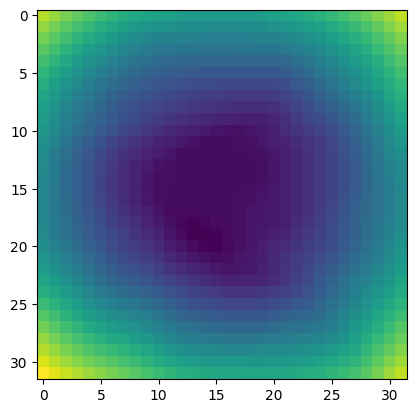

In [128]:
plt.imshow(img3.max(1))

In [129]:
mesh = get_mesh_from_sdf(img3)

In [130]:
mesh.save('test.ply')

In [25]:
all_x_r['image'][i][0].detach().cpu().numpy().min()

-2.0035145